### Import Libraries

In [1]:
import xarray as xr
import OpenVisus as ov
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import rowcol

### Extract Latitude and Longitude from the netcdf file

Please download the netcdf file from the same github repo or from here: https://mega.nz/file/7N8xEa4S#I756lI6N0uf2xaAEDOno2belVW7aX2lv5W1pLFvuRQ4 

Please send an email to aashishpanta0@gmail.com if you have trouble accessing it.

In [3]:
ds=xr.open_dataset('./llc2160_latlon.nc')
print(ds)
lat_center = ds["latitude"].values
lon_center = ds["longitude"].values

<xarray.Dataset> Size: 448MB
Dimensions:    (y: 6480, x: 8640)
Coordinates:
  * y          (y) int64 52kB 0 1 2 3 4 5 6 ... 6474 6475 6476 6477 6478 6479
  * x          (x) int64 69kB 0 1 2 3 4 5 6 ... 8634 8635 8636 8637 8638 8639
Data variables:
    latitude   (y, x) float32 224MB ...
    longitude  (y, x) float32 224MB ...
Attributes:
    title:        LLC2160 Mosaic Grid
    description:  Latitude and Longitude mosaic from LLC2160 faces 0, 1, 3, 4
    Conventions:  CF-1.8
    source:       Generated from MITgcm LLC2160 binary grid data


### Set Variables

In [4]:
eastwest_ocean_velocity_u = "https://nsdf-climate3-origin.nationalresearchplatform.org:50098/nasa/nsdf/climate3/dyamond/mit_output/llc2160_arco/visus.idx"
northsouth_ocean_velocity_v = "https://nsdf-climate3-origin.nationalresearchplatform.org:50098/nasa/nsdf/climate3/dyamond/mit_output//llc2160_v/v_llc2160_x_y_depth.idx"
vertical_velocity_w = "https://nsdf-climate3-origin.nationalresearchplatform.org:50098/nasa/nsdf/climate3/dyamond/mit_output/llc2160_w/llc2160_w.idx"
temperature_theta = "https://nsdf-climate3-origin.nationalresearchplatform.org:50098/nasa/nsdf/climate3/dyamond/mit_output//llc2160_theta/llc2160_theta.idx"
Salinity_salt = "https://nsdf-climate3-origin.nationalresearchplatform.org:50098/nasa/nsdf/climate3/dyamond/mit_output/llc2160_salt/salt_llc2160_x_y_depth.idx"


### Use Array Index to extract Data and Lat/Lon

In [5]:
def extract_data_latlon(field, lat_center, lon_center, x_range, y_range, z=[0,1], quality=0):
    db=ov.LoadDataset(field)
    data = db.read(x=x_range, y=y_range, z=z, quality=quality)[0, :, :]
    lat = lat_center[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    lon = lon_center[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    print("long and lat at left bottom corner", lon.min(), lat.min())
    print("long and lat at right top corner", lon.max(), lat.max())
    return data, lat, lon


### Complete Pipeline: X, Y data Range → Lat/Lon → GeoTIFF Crop

This function takes ranges (x, y) and produces:
1. Lat/Lon plot and coordinate bounds from LLC2160 data
2. Pixel coordinates from GeoTIFF using those bounds  
3. Cropped visualization of that region from the GeoTIFF image

In [6]:
import rasterio


def data_coordinate_to_geotiff_crop(x_range, y_range, field_url, lat_center, lon_center, 
                         geotiff_path='./BlueMarbleNG-TB_2004-12-01_rgb_3600x1800.TIFF',
                         z=[0,1], quality=0, figsize=(12, 6)):
    """
    Complete pipeline: x,y value ranges → Lat/Lon extraction → GeoTIFF crop visualization
    
    Args:
        x_range: [x_min, x_max] 
        y_range: [y_min, y_max]   
        field_url: URL to oceanographic data (e.g., Salinity_salt)
        lat_center, lon_center: LLC2160 coordinate arrays
        geotiff_path: Path to GeoTIFF file
        z: Depth range for data extraction
        quality: Quality parameter for OpenVisus
        figsize: Figure size for plots
    
    Returns:
        Dictionary with all coordinate and pixel information
    """
    
    print(f"STEP 1: Extracting Oceanographic Data and Coordinates")
    print(f"X, Y value range of climate data: x=[{x_range[0]}, {x_range[1]}], y=[{y_range[0]}, {y_range[1]}]")
    
    # Extract data and coordinates from LLC2160
    data_sub, lat_sub, lon_sub = extract_data_latlon(field_url, lat_center, lon_center, 
                                                    x_range, y_range, z, quality)
    
    # Get coordinate bounds
    lat_min, lat_max = lat_sub.min(), lat_sub.max()
    lon_min, lon_max = lon_sub.min(), lon_sub.max()
    
    print(f"Coordinate bounds: Lat [{lat_min:.3f}°, {lat_max:.3f}°], Lon [{lon_min:.3f}°, {lon_max:.3f}°]")
    print(f"Data shape: {data_sub.shape}, Data range: [{data_sub.min():.3f}, {data_sub.max():.3f}]")
    
    print(f"\n  STEP 2: Converting Lat/Lon to GeoTIFF Pixel Coordinates")
    
    # Open GeoTIFF and convert coordinates to pixels
    with rasterio.open(geotiff_path) as src:
        print(f"GeoTIFF: {src.width} x {src.height} pixels")
        print(f"GeoTIFF bounds: {src.bounds}")
        
        # Convert corner coordinates to pixels
        corners = [
            (lat_min, lon_min, "Bottom-Left"),
            (lat_max, lon_min, "Top-Left"), 
            (lat_min, lon_max, "Bottom-Right"),
            (lat_max, lon_max, "Top-Right")
        ]
        
        pixel_coords = []
        print("\nCorner coordinate conversion:")
        
        for lat, lon, corner_name in corners:
            row, col = rowcol(src.transform, lon, lat)
            pixel_coords.append((row, col))
            
            # Check if within bounds
            in_bounds = 0 <= row < src.height and 0 <= col < src.width
            status = "within bound" if in_bounds else "OUT OF BOUNDS"
            
            print(f"  {corner_name:12} ({lat:7.3f}°, {lon:7.3f}°) → Row: {row:4}, Col: {col:4} {status}")
        
        # Get pixel bounds for cropping
        rows = [coord[0] for coord in pixel_coords]
        cols = [coord[1] for coord in pixel_coords] 
        
        # Ensure valid bounds within image
        row_min = max(0, min(rows))
        row_max = min(src.height, max(rows))
        col_min = max(0, min(cols))
        col_max = min(src.width, max(cols))
        
        print(f"\nPixel crop bounds: Rows [{row_min}, {row_max}], Cols [{col_min}, {col_max}]")
        print(f"Crop size: {col_max - col_min} x {row_max - row_min} pixels")
        
        print(f"\n STEP 3: Reading and Cropping GeoTIFF Image")
        
        # Read the cropped region from GeoTIFF
        try:
            # Read RGB bands for the cropped region
            crop_window = rasterio.windows.Window(col_min, row_min, 
                                                 col_max - col_min, row_max - row_min)
            
            # Read RGB bands (assuming bands 1,2,3 are R,G,B)
            red = src.read(1, window=crop_window)
            green = src.read(2, window=crop_window) 
            blue = src.read(3, window=crop_window)
            
            # Stack into RGB image
            rgb_crop = np.stack([red, green, blue], axis=2)
            
            # Get geographic bounds of the crop (returns tuple: left, bottom, right, top)
            crop_bounds = rasterio.windows.bounds(crop_window, src.transform)
            crop_left, crop_bottom, crop_right, crop_top = crop_bounds
            
            print(f"Successfully cropped image: {rgb_crop.shape}")
            print(f"Crop geographic bounds: {crop_bounds}")
            
        except Exception as e:
            print(f"Error reading GeoTIFF crop: {e}")
            return None
    
    print(f"\n STEP 4: Creating 2-Panel Comparison Visualization")
    
    # Create 2-panel comparison plot
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(f'X,Y Range [{x_range[0]}:{x_range[1]}, {y_range[0]}:{y_range[1]}] → Geographic Comparison', 
                 fontsize=14, fontweight='bold')
    
    # Plot 1: LLC2160 Data
    ax1 = axes[0]
    im1 = ax1.imshow(data_sub, cmap="turbo", origin="lower", 
                     extent=[lon_min, lon_max, lat_min, lat_max])
    plt.colorbar(im1, ax=ax1, label='Salinity')
    ax1.set_xlabel('Longitude [°]')
    ax1.set_ylabel('Latitude [°]')
    ax1.set_title('LLC2160 Data (Salinity)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: GeoTIFF Cropped Region
    ax2 = axes[1]
    if rgb_crop.size > 0:
        # Normalize RGB values to 0-1 range if needed
        if rgb_crop.max() > 1:
            rgb_crop_normalized = rgb_crop / 255.0
        else:
            rgb_crop_normalized = rgb_crop
            
        # Use the unpacked crop bounds
        ax2.imshow(rgb_crop_normalized, extent=[crop_left, crop_right, crop_bottom, crop_top])
        ax2.set_xlabel('Longitude [°]')
        ax2.set_ylabel('Latitude [°]')
        ax2.set_title('GeoTIFF Cropped Region')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Crop Failed', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('GeoTIFF Crop (Failed)')
    
    plt.tight_layout()
    plt.show()
    
    # Return comprehensive information
    result = {
        'voxel_range': {'x': x_range, 'y': y_range},
        'coordinate_bounds': {
            'lat_min': lat_min, 'lat_max': lat_max,
            'lon_min': lon_min, 'lon_max': lon_max
        },
        'pixel_bounds': {
            'row_min': row_min, 'row_max': row_max,
            'col_min': col_min, 'col_max': col_max  
        },
        'data_shape': data_sub.shape,
        'crop_shape': rgb_crop.shape if 'rgb_crop' in locals() else None,
        'llc2160_data': data_sub,
        'llc2160_lat': lat_sub,
        'llc2160_lon': lon_sub,
        'geotiff_crop': rgb_crop if 'rgb_crop' in locals() else None,
        'crop_bounds': crop_bounds if 'crop_bounds' in locals() else None
    }
    
    print(f"   Coordinate range: {lat_max - lat_min:.2f}° × {lon_max - lon_min:.2f}°")
    print(f"   LLC2160 data: {data_sub.shape}")
    if 'rgb_crop' in locals():
        print(f"   GeoTIFF crop: {rgb_crop.shape}")
    print(f"   Result dictionary returned with all data")
    
    return result

### Australia


Australia SEA REGION
STEP 1: Extracting Oceanographic Data and Coordinates
X, Y value range of climate data: x=[0, 8460], y=[0, 6480]
long and lat at left bottom corner -180.0 -89.99473
long and lat at right top corner 179.99997 72.03472
Coordinate bounds: Lat [-89.995°, 72.035°], Lon [-180.000°, 180.000°]
Data shape: (6480, 8460), Data range: [0.000, 51.159]

  STEP 2: Converting Lat/Lon to GeoTIFF Pixel Coordinates
GeoTIFF: 3600 x 1800 pixels
GeoTIFF bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

Corner coordinate conversion:
  Bottom-Left  (-89.995°, -180.000°) → Row: 1799, Col:    0 within bound
  Top-Left     ( 72.035°, -180.000°) → Row:  179, Col:    0 within bound
  Bottom-Right (-89.995°, 180.000°) → Row: 1799, Col: 3599 within bound
  Top-Right    ( 72.035°, 180.000°) → Row:  179, Col: 3599 within bound

Pixel crop bounds: Rows [179, 1799], Cols [0, 3599]
Crop size: 3599 x 1620 pixels

 STEP 3: Reading and Cropping GeoTIFF Image
Successfully cropped ima

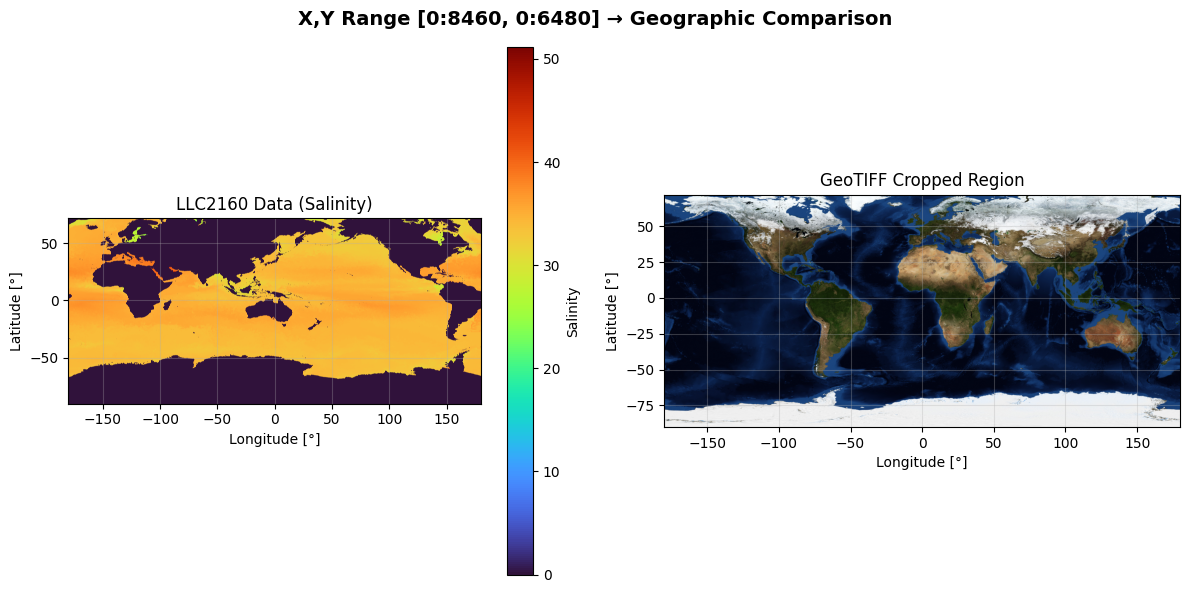

   Coordinate range: 162.03° × 360.00°
   LLC2160 data: (6480, 8460)
   GeoTIFF crop: (1620, 3599, 3)
   Result dictionary returned with all data


In [7]:
# Test 1: Australia Sea region (your existing example)
print("Australia SEA REGION")
print("=" * 50)

# aus_x_range = [3400, 4800]  # Your existing Australia region
# aus_y_range = [2600, 3800]

aus_x_range = [0, 8460]  # Your existing Australia region
aus_y_range = [0, 6480]

result_med = data_coordinate_to_geotiff_crop(
    x_range=aus_x_range,
    y_range=aus_y_range, 
    field_url=Salinity_salt,
    lat_center=lat_center,
    lon_center=lon_center
)

### Agulhaas Ring

Current directory: /home/eliza89/PhD/codes/vis_user_tool/python/metadata
Base path: /home/eliza89/PhD/codes/vis_user_tool
Python directory: /home/eliza89/PhD/codes/vis_user_tool/python
set data dims [0, 8640] [0, 6480] [0, 90] t=[0, 10269]
Agulhaas SEA REGION
STEP 1: Extracting Oceanographic Data and Coordinates
X, Y value range of climate data: x=[1028, 2185], y=[2453, 3248]
long and lat at left bottom corner 4.8541665 -50.09497
long and lat at right top corner 53.020832 -26.392996
Coordinate bounds: Lat [-50.095°, -26.393°], Lon [4.854°, 53.021°]
Data shape: (795, 1157), Data range: [0.000, 27.305]

  STEP 2: Converting Lat/Lon to GeoTIFF Pixel Coordinates
GeoTIFF: 3600 x 1800 pixels
GeoTIFF bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

Corner coordinate conversion:
  Bottom-Left  (-50.095°,   4.854°) → Row: 1400, Col: 1848 within bound
  Top-Left     (-26.393°,   4.854°) → Row: 1163, Col: 1848 within bound
  Bottom-Right (-50.095°,  53.021°) → Row: 1400, Col

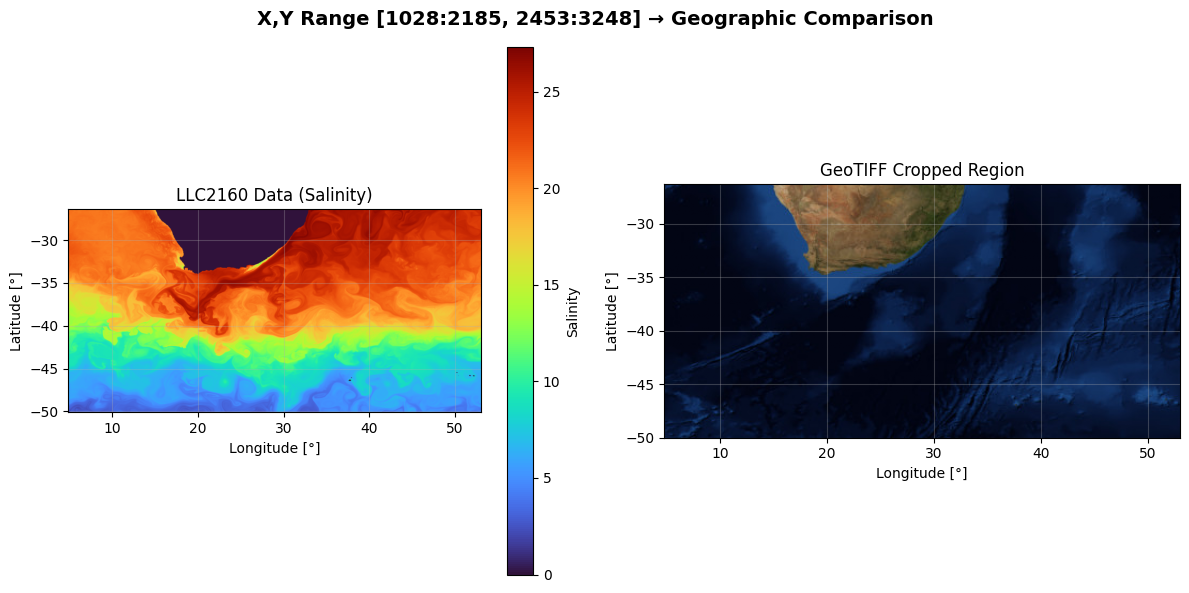

   Coordinate range: 23.70° × 48.17°
   LLC2160 data: (795, 1157)
   GeoTIFF crop: (237, 482, 3)
   Result dictionary returned with all data


In [20]:
import os
import sys

# Get current working directory (notebook location)
current_dir = os.getcwd()  # /home/eliza89/PhD/codes/vis_user_tool/python/metadata

# Navigate to the vis_user_tool base directory
base_path = os.path.dirname(os.path.dirname(current_dir))  # .../vis_user_tool

# Add the `python/` directory to find renderInterface.py
python_dir = os.path.join(base_path, 'python')
if python_dir not in sys.path:
    sys.path.append(python_dir)
    
# Add the `build/renderingApps/py` directory to find vistool_py
build_path = os.path.join(base_path, 'build', 'renderingApps', 'py')
if build_path not in sys.path:
    sys.path.append(build_path)

print(f"Current directory: {current_dir}")
print(f"Base path: {base_path}")
print(f"Python directory: {python_dir}")

import renderInterface

a = renderInterface.AnimationHandler(temperature_theta)

# set render info
a.setDataDim(8640, 6480, 90, 10269);

x_max = a.dataSrc.getLogicBox()[1][0]
y_max = a.dataSrc.getLogicBox()[1][1]

# x_range = [int(x_max*0.057), int(x_max*0.174)]
# y_range = [int(y_max*0.69), int(y_max*0.802)]

a_x_range = [int(a.x_max*0.119), int(a.x_max*0.253)]
a_y_range = [int(a.y_max*0.378667), int(a.y_max*0.501333)]

# x_range = [int(x_max*0.153), int(x_max*0.289)]
# y_range = [int(y_max*0.645), int(y_max*0.735)]

print("Agulhaas SEA REGION")
print("=" * 50)

result_med = data_coordinate_to_geotiff_crop(
    x_range=a_x_range,
    y_range=a_y_range, 
    field_url=temperature_theta,
    lat_center=lat_center,
    lon_center=lon_center
)

### MEDITERRANIAN SEA

Current directory: /home/eliza89/PhD/codes/vis_user_tool/python/metadata
Base path: /home/eliza89/PhD/codes/vis_user_tool
Python directory: /home/eliza89/PhD/codes/vis_user_tool/python
set data dims [0, 8640] [0, 6480] [0, 90] t=[0, 10269]
Meddies SEA REGION
STEP 1: Extracting Oceanographic Data and Coordinates
X, Y value range of climate data: x=[492, 1503], y=[4471, 5196]
long and lat at left bottom corner -17.479166 19.304264
long and lat at right top corner 24.604166 42.834385
Coordinate bounds: Lat [19.304°, 42.834°], Lon [-17.479°, 24.604°]
Data shape: (725, 1011), Data range: [0.000, 44.840]

  STEP 2: Converting Lat/Lon to GeoTIFF Pixel Coordinates
GeoTIFF: 3600 x 1800 pixels
GeoTIFF bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

Corner coordinate conversion:
  Bottom-Left  ( 19.304°, -17.479°) → Row:  706, Col: 1625 within bound
  Top-Left     ( 42.834°, -17.479°) → Row:  471, Col: 1625 within bound
  Bottom-Right ( 19.304°,  24.604°) → Row:  706, Col: 

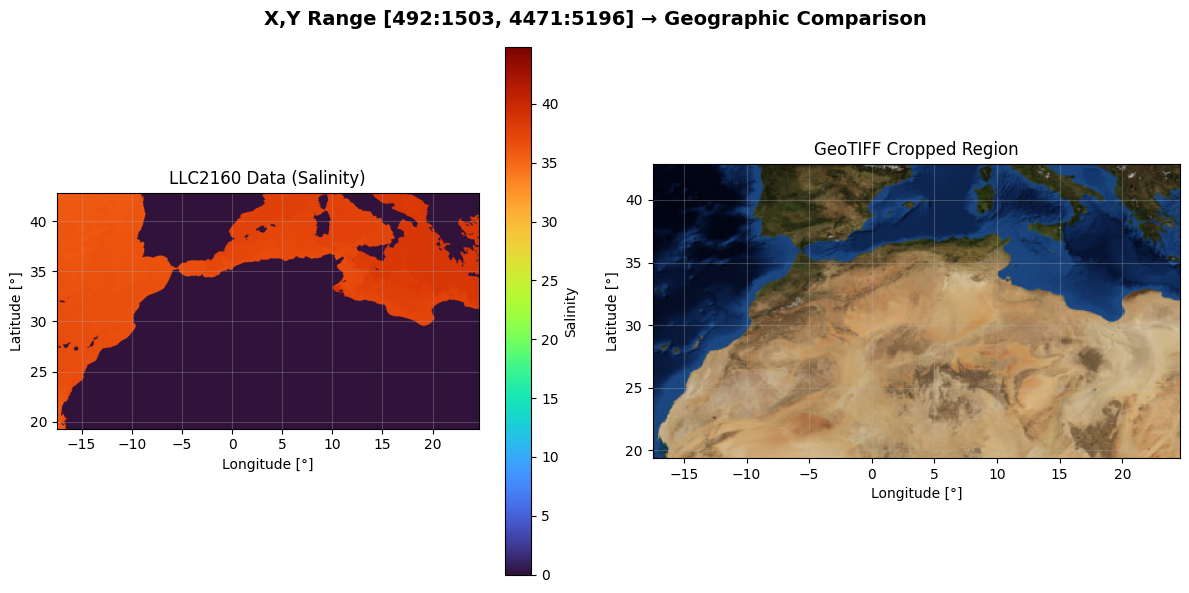

   Coordinate range: 23.53° × 42.08°
   LLC2160 data: (725, 1011)
   GeoTIFF crop: (235, 421, 3)
   Result dictionary returned with all data


In [48]:
import os
import sys

# Get current working directory (notebook location)
current_dir = os.getcwd()  # /home/eliza89/PhD/codes/vis_user_tool/python/metadata

# Navigate to the vis_user_tool base directory
base_path = os.path.dirname(os.path.dirname(current_dir))  # .../vis_user_tool

# Add the `python/` directory to find renderInterface.py
python_dir = os.path.join(base_path, 'python')
if python_dir not in sys.path:
    sys.path.append(python_dir)
    
# Add the `build/renderingApps/py` directory to find vistool_py
build_path = os.path.join(base_path, 'build', 'renderingApps', 'py')
if build_path not in sys.path:
    sys.path.append(build_path)

print(f"Current directory: {current_dir}")
print(f"Base path: {base_path}")
print(f"Python directory: {python_dir}")

import renderInterface

a = renderInterface.AnimationHandler(Salinity_salt)

# set render info
a.setDataDim(8640, 6480, 90, 10269);

x_max = a.dataSrc.getLogicBox()[1][0]
y_max = a.dataSrc.getLogicBox()[1][1]

x_range = [int(x_max*0.057), int(x_max*0.174)]
y_range = [int(y_max*0.69), int(y_max*0.802)]

# x_range = [int(x_max*0.153), int(x_max*0.289)]
# y_range = [int(y_max*0.645), int(y_max*0.735)]

print("Meddies SEA REGION")
print("=" * 50)

result_med = data_coordinate_to_geotiff_crop(
    x_range=x_range,
    y_range=y_range, 
    field_url=Salinity_salt,
    lat_center=lat_center,
    lon_center=lon_center
)

### RED SEA SALINITY

Current directory: /home/eliza89/PhD/codes/vis_user_tool/python/metadata
Base path: /home/eliza89/PhD/codes/vis_user_tool
Python directory: /home/eliza89/PhD/codes/vis_user_tool/python
set data dims [0, 8640] [0, 6480] [0, 90] t=[0, 10269]
RED SEA REGION
STEP 1: Extracting Oceanographic Data and Coordinates
X, Y value range of climate data: x=[1321, 2496], y=[4179, 4762]
long and lat at left bottom corner 17.0625 8.441178
long and lat at right top corner 65.979164 29.406141
Coordinate bounds: Lat [8.441°, 29.406°], Lon [17.062°, 65.979°]
Data shape: (583, 1175), Data range: [0.000, 51.159]

  STEP 2: Converting Lat/Lon to GeoTIFF Pixel Coordinates
GeoTIFF: 3600 x 1800 pixels
GeoTIFF bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

Corner coordinate conversion:
  Bottom-Left  (  8.441°,  17.062°) → Row:  815, Col: 1970 within bound
  Top-Left     ( 29.406°,  17.062°) → Row:  605, Col: 1970 within bound
  Bottom-Right (  8.441°,  65.979°) → Row:  815, Col: 2459 with

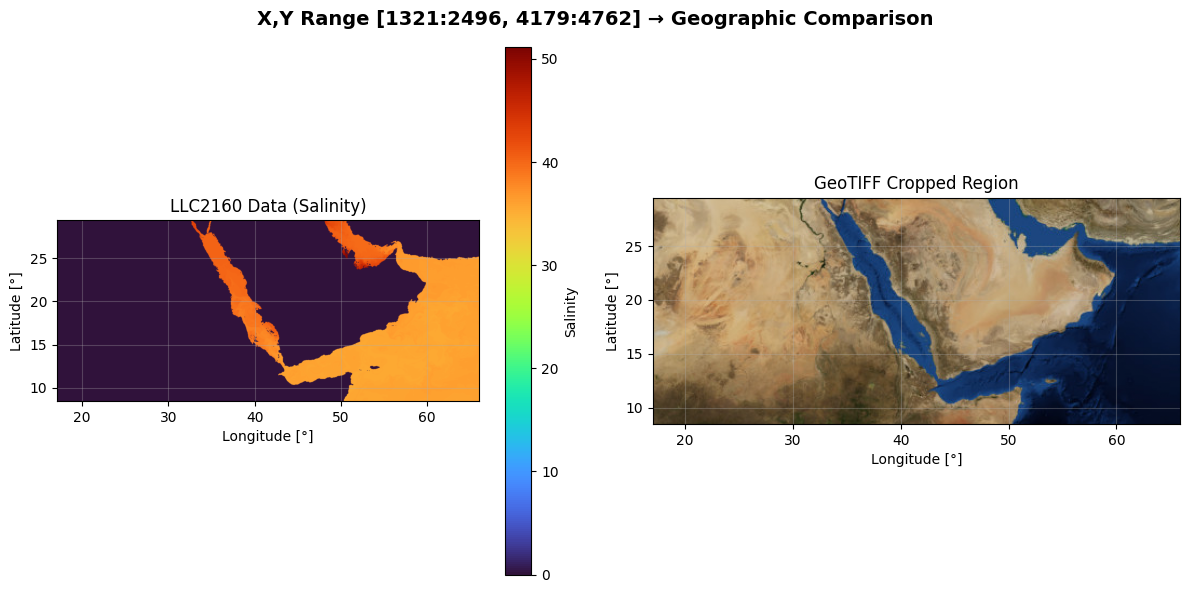

   Coordinate range: 20.96° × 48.92°
   LLC2160 data: (583, 1175)
   GeoTIFF crop: (210, 489, 3)
   Result dictionary returned with all data


In [49]:
import os
import sys

# Get current working directory (notebook location)
current_dir = os.getcwd()  # /home/eliza89/PhD/codes/vis_user_tool/python/metadata

# Navigate to the vis_user_tool base directory
base_path = os.path.dirname(os.path.dirname(current_dir))  # .../vis_user_tool

# Add the `python/` directory to find renderInterface.py
python_dir = os.path.join(base_path, 'python')
if python_dir not in sys.path:
    sys.path.append(python_dir)
    
# Add the `build/renderingApps/py` directory to find vistool_py
build_path = os.path.join(base_path, 'build', 'renderingApps', 'py')
if build_path not in sys.path:
    sys.path.append(build_path)

print(f"Current directory: {current_dir}")
print(f"Base path: {base_path}")
print(f"Python directory: {python_dir}")

import renderInterface

a = renderInterface.AnimationHandler(Salinity_salt)

# set render info
a.setDataDim(8640, 6480, 90, 10269);

x_max = a.dataSrc.getLogicBox()[1][0]
y_max = a.dataSrc.getLogicBox()[1][1]

red_x_range = [int(x_max*0.153), int(x_max*0.289)]
red_y_range = [int(y_max*0.645), int(y_max*0.735)]

print("RED SEA REGION")
print("=" * 50)

result_red = data_coordinate_to_geotiff_crop(
    x_range=red_x_range,
    y_range=red_y_range, 
    field_url=Salinity_salt,
    lat_center=lat_center,
    lon_center=lon_center
)

### Save Cropped GeoTIFF as PNG

Modified function to save the cropped region as PNG files

In [50]:
from PIL import Image
import matplotlib.pyplot as plt

def data_coordinate_to_geotiff_crop_and_save(x_range, y_range, field_url, lat_center, lon_center, 
                         geotiff_path='./BlueMarbleNG-TB_2004-12-01_rgb_3600x1800.TIFF',
                         output_dir='./cropped_images',
                         region_name='region',
                         z=[0,1], quality=0, figsize=(12, 6)):
    """
    Complete pipeline: x,y value ranges → Lat/Lon extraction → GeoTIFF crop → Save as PNG
    
    Args:
        x_range: [x_min, x_max] 
        y_range: [y_min, y_max]   
        field_url: URL to oceanographic data (e.g., Salinity_salt)
        lat_center, lon_center: LLC2160 coordinate arrays
        geotiff_path: Path to GeoTIFF file
        output_dir: Directory to save PNG files
        region_name: Name prefix for saved files
        z: Depth range for data extraction
        quality: Quality parameter for OpenVisus
        figsize: Figure size for plots
    
    Returns:
        Dictionary with all coordinate and pixel information + saved file paths
    """
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"STEP 1: Extracting Oceanographic Data and Coordinates")
    print(f"X, Y value range of climate data: x=[{x_range[0]}, {x_range[1]}], y=[{y_range[0]}, {y_range[1]}]")
    
    # Extract data and coordinates from LLC2160
    data_sub, lat_sub, lon_sub = extract_data_latlon(field_url, lat_center, lon_center, 
                                                    x_range, y_range, z, quality)
    
    # Get coordinate bounds
    lat_min, lat_max = lat_sub.min(), lat_sub.max()
    lon_min, lon_max = lon_sub.min(), lon_sub.max()
    
    print(f"Coordinate bounds: Lat [{lat_min:.3f}°, {lat_max:.3f}°], Lon [{lon_min:.3f}°, {lon_max:.3f}°]")
    print(f"Data shape: {data_sub.shape}, Data range: [{data_sub.min():.3f}, {data_sub.max():.3f}]")
    
    print(f"\n  STEP 2: Converting Lat/Lon to GeoTIFF Pixel Coordinates")
    
    # Open GeoTIFF and convert coordinates to pixels
    with rasterio.open(geotiff_path) as src:
        print(f"GeoTIFF: {src.width} x {src.height} pixels")
        print(f"GeoTIFF bounds: {src.bounds}")
        
        # Convert corner coordinates to pixels
        corners = [
            (lat_min, lon_min, "Bottom-Left"),
            (lat_max, lon_min, "Top-Left"), 
            (lat_min, lon_max, "Bottom-Right"),
            (lat_max, lon_max, "Top-Right")
        ]
        
        pixel_coords = []
        print("\nCorner coordinate conversion:")
        
        for lat, lon, corner_name in corners:
            row, col = rowcol(src.transform, lon, lat)
            pixel_coords.append((row, col))
            
            # Check if within bounds
            in_bounds = 0 <= row < src.height and 0 <= col < src.width
            status = "within bound" if in_bounds else "OUT OF BOUNDS"
            
            print(f"  {corner_name:12} ({lat:7.3f}°, {lon:7.3f}°) → Row: {row:4}, Col: {col:4} {status}")
        
        # Get pixel bounds for cropping
        rows = [coord[0] for coord in pixel_coords]
        cols = [coord[1] for coord in pixel_coords] 
        
        # Ensure valid bounds within image
        row_min = max(0, min(rows))
        row_max = min(src.height, max(rows))
        col_min = max(0, min(cols))
        col_max = min(src.width, max(cols))
        
        print(f"\nPixel crop bounds: Rows [{row_min}, {row_max}], Cols [{col_min}, {col_max}]")
        print(f"Crop size: {col_max - col_min} x {row_max - row_min} pixels")
        
        print(f"\n STEP 3: Reading and Cropping GeoTIFF Image")
        
        # Read the cropped region from GeoTIFF
        try:
            # Read RGB bands for the cropped region
            crop_window = rasterio.windows.Window(col_min, row_min, 
                                                 col_max - col_min, row_max - row_min)
            
            # Read RGB bands (assuming bands 1,2,3 are R,G,B)
            red = src.read(1, window=crop_window)
            green = src.read(2, window=crop_window) 
            blue = src.read(3, window=crop_window)
            
            # Stack into RGB image
            rgb_crop = np.stack([red, green, blue], axis=2)
            
            # Get geographic bounds of the crop (returns tuple: left, bottom, right, top)
            crop_bounds = rasterio.windows.bounds(crop_window, src.transform)
            crop_left, crop_bottom, crop_right, crop_top = crop_bounds
            
            print(f"Successfully cropped image: {rgb_crop.shape}")
            print(f"Crop geographic bounds: {crop_bounds}")
            
        except Exception as e:
            print(f"Error reading GeoTIFF crop: {e}")
            return None
    
    print(f"\n STEP 4: Saving Cropped GeoTIFF as PNG")
    
    # Save the cropped GeoTIFF region as PNG
    saved_files = []
    
    if rgb_crop.size > 0:
        # Normalize RGB values to 0-255 range for PNG
        if rgb_crop.max() <= 1.0:
            rgb_crop_uint8 = (rgb_crop * 255).astype(np.uint8)
        else:
            rgb_crop_uint8 = rgb_crop.astype(np.uint8)
        
        # Create PNG filename
        png_filename = f"{region_name}_geotiff_crop_x{x_range[0]}-{x_range[1]}_y{y_range[0]}-{y_range[1]}.png"
        png_filepath = os.path.join(output_dir, png_filename)
        
        # Save using PIL
        img = Image.fromarray(rgb_crop_uint8, 'RGB')
        img.save(png_filepath)
        saved_files.append(png_filepath)
        
        print(f"✓ Saved cropped GeoTIFF as: {png_filepath}")
        print(f"  Image size: {img.size} pixels")
        
        # Also save the LLC2160 data plot as PNG
        llc_filename = f"{region_name}_llc2160_data_x{x_range[0]}-{x_range[1]}_y{y_range[0]}-{y_range[1]}.png"
        llc_filepath = os.path.join(output_dir, llc_filename)
        
        # Create a figure for just the LLC2160 data
        fig_llc, ax_llc = plt.subplots(1, 1, figsize=(8, 6))
        im = ax_llc.imshow(data_sub, cmap="turbo", origin="lower", 
                          extent=[lon_min, lon_max, lat_min, lat_max])
        plt.colorbar(im, ax=ax_llc, label='Data Value')
        ax_llc.set_xlabel('Longitude [°]')
        ax_llc.set_ylabel('Latitude [°]')
        ax_llc.set_title(f'LLC2160 Data - {region_name}')
        ax_llc.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(llc_filepath, dpi=300, bbox_inches='tight')
        plt.close()
        saved_files.append(llc_filepath)
        
        print(f"✓ Saved LLC2160 data as: {llc_filepath}")
    
    print(f"\n STEP 5: Creating Visualization")
    
    # Create 2-panel comparison plot
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(f'{region_name}: X,Y Range [{x_range[0]}:{x_range[1]}, {y_range[0]}:{y_range[1]}] → Geographic Comparison', 
                 fontsize=14, fontweight='bold')
    
    # Plot 1: LLC2160 Data
    ax1 = axes[0]
    im1 = ax1.imshow(data_sub, cmap="turbo", origin="lower", 
                     extent=[lon_min, lon_max, lat_min, lat_max])
    plt.colorbar(im1, ax=ax1, label='Data Value')
    ax1.set_xlabel('Longitude [°]')
    ax1.set_ylabel('Latitude [°]')
    ax1.set_title('LLC2160 Data')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: GeoTIFF Cropped Region
    ax2 = axes[1]
    if rgb_crop.size > 0:
        # Normalize RGB values to 0-1 range for display
        if rgb_crop.max() > 1:
            rgb_crop_normalized = rgb_crop / 255.0
        else:
            rgb_crop_normalized = rgb_crop
            
        # Use the unpacked crop bounds
        ax2.imshow(rgb_crop_normalized, extent=[crop_left, crop_right, crop_bottom, crop_top])
        ax2.set_xlabel('Longitude [°]')
        ax2.set_ylabel('Latitude [°]')
        ax2.set_title('GeoTIFF Cropped Region')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Crop Failed', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('GeoTIFF Crop (Failed)')
    
    plt.tight_layout()
    plt.show()
    
    # Return comprehensive information
    result = {
        'voxel_range': {'x': x_range, 'y': y_range},
        'coordinate_bounds': {
            'lat_min': lat_min, 'lat_max': lat_max,
            'lon_min': lon_min, 'lon_max': lon_max
        },
        'pixel_bounds': {
            'row_min': row_min, 'row_max': row_max,
            'col_min': col_min, 'col_max': col_max  
        },
        'data_shape': data_sub.shape,
        'crop_shape': rgb_crop.shape if 'rgb_crop' in locals() else None,
        'llc2160_data': data_sub,
        'llc2160_lat': lat_sub,
        'llc2160_lon': lon_sub,
        'geotiff_crop': rgb_crop if 'rgb_crop' in locals() else None,
        'crop_bounds': crop_bounds if 'crop_bounds' in locals() else None,
        'saved_files': saved_files
    }
    
    print(f"\n   Summary:")
    print(f"   Coordinate range: {lat_max - lat_min:.2f}° × {lon_max - lon_min:.2f}°")
    print(f"   LLC2160 data: {data_sub.shape}")
    if 'rgb_crop' in locals():
        print(f"   GeoTIFF crop: {rgb_crop.shape}")
    print(f"   Files saved: {len(saved_files)}")
    for file_path in saved_files:
        print(f"     - {file_path}")
    
    return result

### Test: Save Cropped Regions as PNG Files

Let's test the new function with different regions and save them as PNG files.


SAVING: Mediterranean SEA REGION
Current directory: /home/eliza89/PhD/codes/vis_user_tool/python/metadata
Base path: /home/eliza89/PhD/codes/vis_user_tool
Python directory: /home/eliza89/PhD/codes/vis_user_tool/python
set data dims [0, 8640] [0, 6480] [0, 90] t=[0, 10269]
STEP 1: Extracting Oceanographic Data and Coordinates
X, Y value range of climate data: x=[492, 1503], y=[4471, 5196]
long and lat at left bottom corner -17.479166 19.304264
long and lat at right top corner 24.604166 42.834385
Coordinate bounds: Lat [19.304°, 42.834°], Lon [-17.479°, 24.604°]
Data shape: (725, 1011), Data range: [0.000, 44.840]

  STEP 2: Converting Lat/Lon to GeoTIFF Pixel Coordinates
GeoTIFF: 3600 x 1800 pixels
GeoTIFF bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

Corner coordinate conversion:
  Bottom-Left  ( 19.304°, -17.479°) → Row:  706, Col: 1625 within bound
  Top-Left     ( 42.834°, -17.479°) → Row:  471, Col: 1625 within bound
  Bottom-Right ( 19.304°,  24.604°) → R

/tmp/ipykernel_3636962/3337821368.py:130: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(rgb_crop_uint8, 'RGB')


✓ Saved LLC2160 data as: ./saved_crops/mediterranean_sea_llc2160_data_x492-1503_y4471-5196.png

 STEP 5: Creating Visualization


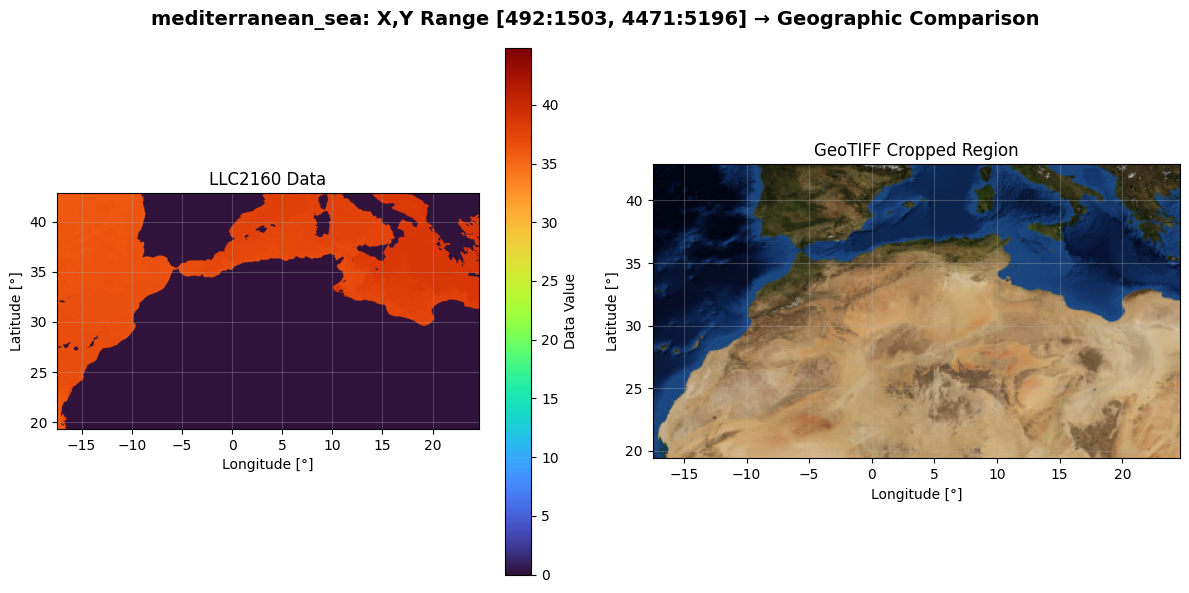


   Summary:
   Coordinate range: 23.53° × 42.08°
   LLC2160 data: (725, 1011)
   GeoTIFF crop: (235, 421, 3)
   Files saved: 2
     - ./saved_crops/mediterranean_sea_geotiff_crop_x492-1503_y4471-5196.png
     - ./saved_crops/mediterranean_sea_llc2160_data_x492-1503_y4471-5196.png


In [51]:
# Test 2: Save Mediterranean Sea region  
import rasterio
from rasterio.transform import rowcol
print("\nSAVING: Mediterranean SEA REGION")
print("=" * 50)
import os
import sys

# Get current working directory (notebook location)
current_dir = os.getcwd()  # /home/eliza89/PhD/codes/vis_user_tool/python/metadata

# Navigate to the vis_user_tool base directory
base_path = os.path.dirname(os.path.dirname(current_dir))  # .../vis_user_tool

# Add the `python/` directory to find renderInterface.py
python_dir = os.path.join(base_path, 'python')
if python_dir not in sys.path:
    sys.path.append(python_dir)
    
# Add the `build/renderingApps/py` directory to find vistool_py
build_path = os.path.join(base_path, 'build', 'renderingApps', 'py')
if build_path not in sys.path:
    sys.path.append(build_path)

print(f"Current directory: {current_dir}")
print(f"Base path: {base_path}")
print(f"Python directory: {python_dir}")

import renderInterface


a = renderInterface.AnimationHandler(Salinity_salt)
a.setDataDim(8640, 6480, 90, 10269)

x_max = a.dataSrc.getLogicBox()[1][0]
y_max = a.dataSrc.getLogicBox()[1][1]

med_x_range = [int(x_max*0.057), int(x_max*0.174)]
med_y_range = [int(y_max*0.69), int(y_max*0.802)]

result_med = data_coordinate_to_geotiff_crop_and_save(
    x_range=med_x_range,
    y_range=med_y_range, 
    field_url=Salinity_salt,
    lat_center=lat_center,
    lon_center=lon_center,
    output_dir='./saved_crops',
    region_name='mediterranean_sea'
)


SAVING: Agulhas Ring REGION
set data dims [0, 8640] [0, 6480] [0, 90] t=[0, 10269]
STEP 1: Extracting Oceanographic Data and Coordinates
X, Y value range of climate data: x=[1028, 2185], y=[2453, 3248]
long and lat at left bottom corner 4.8541665 -50.09497
long and lat at right top corner 53.020832 -26.392996
Coordinate bounds: Lat [-50.095°, -26.393°], Lon [4.854°, 53.021°]
Data shape: (795, 1157), Data range: [0.000, 27.305]

  STEP 2: Converting Lat/Lon to GeoTIFF Pixel Coordinates
GeoTIFF: 3600 x 1800 pixels
GeoTIFF bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

Corner coordinate conversion:
  Bottom-Left  (-50.095°,   4.854°) → Row: 1400, Col: 1848 within bound
  Top-Left     (-26.393°,   4.854°) → Row: 1163, Col: 1848 within bound
  Bottom-Right (-50.095°,  53.021°) → Row: 1400, Col: 2330 within bound
  Top-Right    (-26.393°,  53.021°) → Row: 1163, Col: 2330 within bound

Pixel crop bounds: Rows [1163, 1400], Cols [1848, 2330]
Crop size: 482 x 237 pixels

/tmp/ipykernel_3636962/3337821368.py:130: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(rgb_crop_uint8, 'RGB')


✓ Saved LLC2160 data as: ./saved_crops/agulhas_ring_llc2160_data_x1028-2185_y2453-3248.png

 STEP 5: Creating Visualization


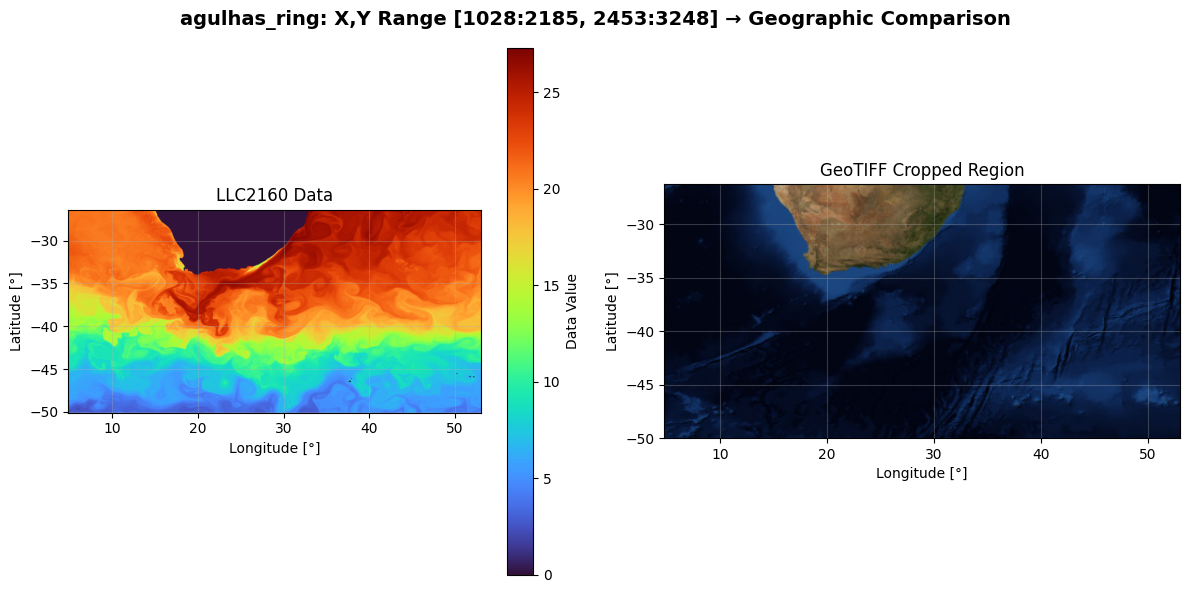


   Summary:
   Coordinate range: 23.70° × 48.17°
   LLC2160 data: (795, 1157)
   GeoTIFF crop: (237, 482, 3)
   Files saved: 2
     - ./saved_crops/agulhas_ring_geotiff_crop_x1028-2185_y2453-3248.png
     - ./saved_crops/agulhas_ring_llc2160_data_x1028-2185_y2453-3248.png


In [52]:
# Test 3: Save Agulhas Ring region
print("\nSAVING: Agulhas Ring REGION")
print("=" * 50)

# Use the Agulhas coordinates from your existing code
a_temp = renderInterface.AnimationHandler(temperature_theta)
a_temp.setDataDim(8640, 6480, 90, 10269)

x_max_temp = a_temp.dataSrc.getLogicBox()[1][0]
y_max_temp = a_temp.dataSrc.getLogicBox()[1][1]

agulhas_x_range = [int(x_max_temp*0.119), int(x_max_temp*0.253)]
agulhas_y_range = [int(y_max_temp*0.378667), int(y_max_temp*0.501333)]

result_agulhas = data_coordinate_to_geotiff_crop_and_save(
    x_range=agulhas_x_range,
    y_range=agulhas_y_range, 
    field_url=temperature_theta,
    lat_center=lat_center,
    lon_center=lon_center,
    output_dir='./saved_crops',
    region_name='agulhas_ring'
)

### Create Land-Only Mask (Remove Sea, Keep Land Transparent Background)

Function to create a PNG with only land areas visible and sea areas as transparent mask.

In [62]:
def create_land_mask_from_sea_coordinates(x_range, y_range, field_url, lat_center, lon_center, 
                         geotiff_path='./BlueMarbleNG-TB_2004-12-01_rgb_3600x1800.TIFF',
                         output_dir='./land_masks',
                         region_name='region',
                         z=[0,1], quality=0, 
                         sea_threshold=0.01,  # Values below this are land areas (will be kept visible)
                         figsize=(12, 6)):
    """
    CORRECTED APPROACH: Make sea areas transparent by converting sea lat/lon directly to GeoTIFF pixels
    
    Steps:
    1. Extract oceanographic data and get lat/lon coordinates  
    2. Identify land pixels where field values ≈ 0 (for salinity data)
    3. Convert sea lat/lon coordinates to GeoTIFF pixel coordinates
    4. Make sea areas transparent, keep land areas opaque
    
    Args:
        x_range, y_range: Data coordinate ranges
        field_url: Oceanographic data URL (salinity, temperature, etc.)
        lat_center, lon_center: LLC2160 coordinate arrays
        geotiff_path: Path to GeoTIFF file
        output_dir: Directory to save mask files
        region_name: Name prefix for saved files
        z, quality: OpenVisus parameters
        sea_threshold: Values below this threshold are LAND areas (kept visible)
        figsize: Figure size for visualization
    
    Returns:
        Dictionary with mask data and saved file paths
    """
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"STEP 1: Extract Oceanographic Data and Coordinates")
    print(f"Field URL: {field_url}")
    print(f"X, Y range: x=[{x_range[0]}, {x_range[1]}], y=[{y_range[0]}, {y_range[1]}]")
    
    # Extract oceanographic data AND coordinate arrays
    data_sub, lat_sub, lon_sub = extract_data_latlon(field_url, lat_center, lon_center, 
                                                    x_range, y_range, z, quality)
    
    print(f"Data shape: {data_sub.shape}")
    print(f"Data range: [{data_sub.min():.6f}, {data_sub.max():.6f}]")
    print(f"Coordinate arrays shape: lat={lat_sub.shape}, lon={lon_sub.shape}")
    
    # CORRECTED: For salinity data - Land has ~0 values, Sea has high values (35-40 PSU)
    land_mask = np.abs(data_sub) <= sea_threshold  # True where land (≈0 salinity)
    sea_mask = ~land_mask  # True where sea (high salinity values)
    
    print(f"Land threshold: {sea_threshold} (values below this are land)")
    print(f"Land pixels: {land_mask.sum()} / {land_mask.size} ({100*land_mask.sum()/land_mask.size:.1f}%)")
    print(f"Sea pixels: {sea_mask.sum()} / {sea_mask.size} ({100*sea_mask.sum()/sea_mask.size:.1f}%)")
    
    # Get lat/lon coordinates of SEA areas (these will be made transparent)
    sea_lat_coords = lat_sub[sea_mask]
    sea_lon_coords = lon_sub[sea_mask]
    
    print(f"Sea coordinate ranges (will be made transparent):")
    print(f"  Lat: [{sea_lat_coords.min():.3f}°, {sea_lat_coords.max():.3f}°]")
    print(f"  Lon: [{sea_lon_coords.min():.3f}°, {sea_lon_coords.max():.3f}°]")
    
    print(f"\nSTEP 2: Get GeoTIFF Crop for the Region")
    
    # Get overall region bounds for GeoTIFF cropping
    lat_min, lat_max = lat_sub.min(), lat_sub.max()
    lon_min, lon_max = lon_sub.min(), lon_sub.max()
    
    with rasterio.open(geotiff_path) as src:
        print(f"GeoTIFF: {src.width} x {src.height} pixels")
        
        # Convert region bounds to pixel coordinates for cropping
        corners = [
            (lat_min, lon_min, "Bottom-Left"),
            (lat_max, lon_min, "Top-Left"), 
            (lat_min, lon_max, "Bottom-Right"),
            (lat_max, lon_max, "Top-Right")
        ]
        
        pixel_coords = []
        for lat, lon, corner_name in corners:
            row, col = rowcol(src.transform, lon, lat)
            pixel_coords.append((row, col))
            in_bounds = 0 <= row < src.height and 0 <= col < src.width
            print(f"  {corner_name:12} ({lat:7.3f}°, {lon:8.3f}°) → Row: {row:4}, Col: {col:4}")
        
        # Get pixel bounds for cropping
        rows = [coord[0] for coord in pixel_coords]
        cols = [coord[1] for coord in pixel_coords] 
        
        row_min = max(0, min(rows))
        row_max = min(src.height, max(rows))
        col_min = max(0, min(cols))
        col_max = min(src.width, max(cols))
        
        print(f"GeoTIFF crop bounds: Rows [{row_min}, {row_max}], Cols [{col_min}, {col_max}]")
        
        # Read RGB crop
        crop_window = rasterio.windows.Window(col_min, row_min, 
                                             col_max - col_min, row_max - row_min)
        
        red = src.read(1, window=crop_window)
        green = src.read(2, window=crop_window) 
        blue = src.read(3, window=crop_window)
        
        rgb_crop = np.stack([red, green, blue], axis=2)
        crop_bounds = rasterio.windows.bounds(crop_window, src.transform)
        
        print(f"RGB crop shape: {rgb_crop.shape}")
        print(f"Crop geographic bounds: {crop_bounds}")
        
        print(f"\nSTEP 3: Convert Sea Lat/Lon to GeoTIFF Pixels and Make Transparent")
        
        # Convert sea coordinates to pixel coordinates within the cropped region
        sea_pixel_rows = []
        sea_pixel_cols = []
        
        for lat, lon in zip(sea_lat_coords, sea_lon_coords):
            # Get global pixel coordinates
            global_row, global_col = rowcol(src.transform, lon, lat)
            
            # Convert to coordinates within the crop
            crop_row = global_row - row_min
            crop_col = global_col - col_min
            
            # Check if within crop bounds
            if 0 <= crop_row < rgb_crop.shape[0] and 0 <= crop_col < rgb_crop.shape[1]:
                sea_pixel_rows.append(crop_row)
                sea_pixel_cols.append(crop_col)
        
        print(f"Found {len(sea_pixel_rows)} sea pixels within GeoTIFF crop (these will be made transparent)")
        
        # Create RGBA image
        rgba_result = np.zeros((rgb_crop.shape[0], rgb_crop.shape[1], 4), dtype=np.uint8)
        
        # Normalize RGB to 0-255 range
        if rgb_crop.max() <= 1.0:
            rgb_uint8 = (rgb_crop * 255).astype(np.uint8)
        else:
            rgb_uint8 = rgb_crop.astype(np.uint8)
        
        # Start with all pixels opaque (showing full GeoTIFF)
        rgba_result[:, :, :3] = rgb_uint8
        rgba_result[:, :, 3] = 255  # All opaque initially
        
        # Make ONLY sea pixels transparent
        if len(sea_pixel_rows) > 0:
            sea_rows_array = np.array(sea_pixel_rows)
            sea_cols_array = np.array(sea_pixel_cols)
            
            # Make sea pixels transparent (removes ocean areas, keeps land)
            rgba_result[sea_rows_array, sea_cols_array, 3] = 0
        
        # Count final results
        transparent_count = (rgba_result[:, :, 3] == 0).sum()
        opaque_count = (rgba_result[:, :, 3] == 255).sum()
        
        print(f"Final result:")
        print(f"  Transparent pixels (sea): {transparent_count:,} ({100*transparent_count/rgba_result[:,:,3].size:.1f}%)")
        print(f"  Opaque pixels (land): {opaque_count:,} ({100*opaque_count/rgba_result[:,:,3].size:.1f}%)")
    
    print(f"\nSTEP 4: Save Results")
    
    saved_files = []
    
    # Save land-only PNG
    land_png_filename = f"{region_name}_land.png"
    land_png_filepath = os.path.join(output_dir, land_png_filename)
    
    land_img = Image.fromarray(rgba_result, 'RGBA')
    land_img.save(land_png_filepath)
    saved_files.append(land_png_filepath)
    
    print(f"✓ Saved CORRECTED land mask: {land_png_filepath}")
    
    # Save comparison visualization
    comparison_filename = f"{region_name}.png"
    comparison_filepath = os.path.join(output_dir, comparison_filename)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{region_name}: CORRECTED Land Mask (Keep Land, Remove Sea)', fontsize=14, fontweight='bold')
    
    # Panel 1: Original oceanographic data
    ax1 = axes[0,0]
    im1 = ax1.imshow(data_sub, cmap="turbo", origin="lower") 
    plt.colorbar(im1, ax=ax1, label='Salinity')
    ax1.set_title('1. Salinity Data\n(Low=Land, High=Sea)')
    
    # Panel 2: Land mask (white=land areas that will be kept)
    ax2 = axes[0,1]
    ax2.imshow(land_mask, cmap="gray", origin="lower")  # white=land (keep)
    ax2.set_title('2. Land Areas (White=Will Be Kept)')
    
    # Panel 3: Original GeoTIFF crop
    ax3 = axes[1,0]
    if rgb_crop.max() > 1:
        rgb_display = rgb_crop / 255.0
    else:
        rgb_display = rgb_crop
    ax3.imshow(rgb_display)
    ax3.set_title('3. Original GeoTIFF')
    
    # Panel 4: CORRECTED result - only land visible!
    ax4 = axes[1,1]
    ax4.imshow(rgba_result)
    ax4.set_title('4. CORRECTED: Only Land Visible!')
    
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.savefig(comparison_filepath, dpi=300, bbox_inches='tight')
    plt.close()
    saved_files.append(comparison_filepath)
    
    print(f"✓ Saved comparison: {comparison_filepath}")
    
    # Return results
    result = {
        'approach': 'corrected_sea_coordinates_to_geotiff_pixels',
        'voxel_range': {'x': x_range, 'y': y_range},
        'coordinate_bounds': {
            'lat_min': lat_min, 'lat_max': lat_max,
            'lon_min': lon_min, 'lon_max': lon_max
        },
        'ocean_data': data_sub,
        'land_mask': land_mask,  # Fixed: land_mask is where salinity ≈ 0
        'sea_mask': sea_mask,    # Fixed: sea_mask is where salinity > threshold
        'sea_coordinates': {'lat': sea_lat_coords, 'lon': sea_lon_coords},
        'geotiff_crop': rgb_crop,
        'final_rgba': rgba_result,
        'sea_threshold': sea_threshold,
        'transparent_percentage': 100 * transparent_count / rgba_result[:,:,3].size,
        'saved_files': saved_files
    }
    
    
    print(f"{'='*70}")
    print(f"Region: {region_name}")
    print(f"Land threshold: {sea_threshold} (salinity below this = land)")
    print(f"Sea areas made transparent: {result['transparent_percentage']:.1f}%")
    print(f"Logic: Low salinity (≈0) = Land (kept), High salinity = Sea (removed)")
    print(f"Output files: {len(saved_files)}")
    for file_path in saved_files:
        file_size_kb = os.path.getsize(file_path) / 1024
        print(f"  - {os.path.basename(file_path)} ({file_size_kb:.1f} KB)")
    print(f"Picture 4 should now show ONLY land areas! 🎯")
    print(f"{'='*70}")
    
    return result

In [63]:
# Test the new coordinate-based approach
import os
import sys

# Get current working directory (notebook location)
current_dir = os.getcwd()  # /home/eliza89/PhD/codes/vis_user_tool/python/metadata

# Navigate to the vis_user_tool base directory
base_path = os.path.dirname(os.path.dirname(current_dir))  # .../vis_user_tool

# Add the `python/` directory to find renderInterface.py
python_dir = os.path.join(base_path, 'python')
if python_dir not in sys.path:
    sys.path.append(python_dir)
    
# Add the `build/renderingApps/py` directory to find vistool_py
build_path = os.path.join(base_path, 'build', 'renderingApps', 'py')
if build_path not in sys.path:
    sys.path.append(build_path)

print(f"Current directory: {current_dir}")
print(f"Base path: {base_path}")
print(f"Python directory: {python_dir}")

import renderInterface


a = renderInterface.AnimationHandler(Salinity_salt)
a.setDataDim(8640, 6480, 90, 10269)

x_max = a.dataSrc.getLogicBox()[1][0]
y_max = a.dataSrc.getLogicBox()[1][1]

med_x_range = [int(x_max*0.057), int(x_max*0.174)]
med_y_range = [int(y_max*0.69), int(y_max*0.802)]

land_result_fixed = create_land_mask_from_sea_coordinates(
    x_range=med_x_range, 
    y_range=med_y_range,
    field_url=Salinity_salt,
    lat_center=lat_center, 
    lon_center=lon_center,
    geotiff_path='./BlueMarbleNG-TB_2004-12-01_rgb_3600x1800.TIFF',
    output_dir='./land_masks',
    region_name='mediterranean_mask',
    z=[0, 1], 
    quality=0,
    sea_threshold=0.01  # Salinity ≈ 0 indicates sea areas
)

Current directory: /home/eliza89/PhD/codes/vis_user_tool/python/metadata
Base path: /home/eliza89/PhD/codes/vis_user_tool
Python directory: /home/eliza89/PhD/codes/vis_user_tool/python
set data dims [0, 8640] [0, 6480] [0, 90] t=[0, 10269]
STEP 1: Extract Oceanographic Data and Coordinates
Field URL: https://nsdf-climate3-origin.nationalresearchplatform.org:50098/nasa/nsdf/climate3/dyamond/mit_output/llc2160_salt/salt_llc2160_x_y_depth.idx
X, Y range: x=[492, 1503], y=[4471, 5196]
set data dims [0, 8640] [0, 6480] [0, 90] t=[0, 10269]
STEP 1: Extract Oceanographic Data and Coordinates
Field URL: https://nsdf-climate3-origin.nationalresearchplatform.org:50098/nasa/nsdf/climate3/dyamond/mit_output/llc2160_salt/salt_llc2160_x_y_depth.idx
X, Y range: x=[492, 1503], y=[4471, 5196]
long and lat at left bottom corner -17.479166 19.304264
long and lat at right top corner 24.604166 42.834385
Data shape: (725, 1011)
Data range: [0.000000, 44.839993]
Coordinate arrays shape: lat=(725, 1011), lon=

/tmp/ipykernel_3636962/3614513115.py:170: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  land_img = Image.fromarray(rgba_result, 'RGBA')


✓ Saved comparison: ./land_masks/mediterranean_mask.png
Region: mediterranean_mask
Land threshold: 0.01 (salinity below this = land)
Sea areas made transparent: 33.7%
Logic: Low salinity (≈0) = Land (kept), High salinity = Sea (removed)
Output files: 2
  - mediterranean_mask_land.png (172.5 KB)
  - mediterranean_mask.png (677.4 KB)
Picture 4 should now show ONLY land areas! 🎯


In [64]:
# Test the new coordinate-based approach
import os
import sys

# Get current working directory (notebook location)
current_dir = os.getcwd()  # /home/eliza89/PhD/codes/vis_user_tool/python/metadata

# Navigate to the vis_user_tool base directory
base_path = os.path.dirname(os.path.dirname(current_dir))  # .../vis_user_tool

# Add the `python/` directory to find renderInterface.py
python_dir = os.path.join(base_path, 'python')
if python_dir not in sys.path:
    sys.path.append(python_dir)
    
# Add the `build/renderingApps/py` directory to find vistool_py
build_path = os.path.join(base_path, 'build', 'renderingApps', 'py')
if build_path not in sys.path:
    sys.path.append(build_path)

print(f"Current directory: {current_dir}")
print(f"Base path: {base_path}")
print(f"Python directory: {python_dir}")

import renderInterface


a = renderInterface.AnimationHandler(Salinity_salt)
a.setDataDim(8640, 6480, 90, 10269)

x_max = a.dataSrc.getLogicBox()[1][0]
y_max = a.dataSrc.getLogicBox()[1][1]

med_x_range = [int(a.x_max*0.119), int(a.x_max*0.253)]
med_y_range = [int(a.y_max*0.378667), int(a.y_max*0.501333)]

land_result_fixed = create_land_mask_from_sea_coordinates(
    x_range=med_x_range, 
    y_range=med_y_range,
    field_url=Salinity_salt,
    lat_center=lat_center, 
    lon_center=lon_center,
    geotiff_path='./BlueMarbleNG-TB_2004-12-01_rgb_3600x1800.TIFF',
    output_dir='./land_masks',
    region_name='agulhaas_mask',
    z=[0, 1], 
    quality=0,
    sea_threshold=0.01  # Salinity ≈ 0 indicates sea areas
)

Current directory: /home/eliza89/PhD/codes/vis_user_tool/python/metadata
Base path: /home/eliza89/PhD/codes/vis_user_tool
Python directory: /home/eliza89/PhD/codes/vis_user_tool/python
set data dims [0, 8640] [0, 6480] [0, 90] t=[0, 10269]
STEP 1: Extract Oceanographic Data and Coordinates
Field URL: https://nsdf-climate3-origin.nationalresearchplatform.org:50098/nasa/nsdf/climate3/dyamond/mit_output/llc2160_salt/salt_llc2160_x_y_depth.idx
X, Y range: x=[1028, 2185], y=[2453, 3248]
long and lat at left bottom corner 4.8541665 -50.09497
long and lat at right top corner 53.020832 -26.392996
Data shape: (795, 1157)
Data range: [0.000000, 35.891644]
Coordinate arrays shape: lat=(795, 1157), lon=(795, 1157)
Land threshold: 0.01 (values below this are land)
Land pixels: 75734 / 919815 (8.2%)
Sea pixels: 844081 / 919815 (91.8%)
Sea coordinate ranges (will be made transparent):
  Lat: [-50.095°, -26.393°]
  Lon: [4.854°, 53.021°]

STEP 2: Get GeoTIFF Crop for the Region
GeoTIFF: 3600 x 1800 pi

/tmp/ipykernel_3636962/3614513115.py:170: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  land_img = Image.fromarray(rgba_result, 'RGBA')


✓ Saved comparison: ./land_masks/agulhaas_mask.png
Region: agulhaas_mask
Land threshold: 0.01 (salinity below this = land)
Sea areas made transparent: 90.8%
Logic: Low salinity (≈0) = Land (kept), High salinity = Sea (removed)
Output files: 2
  - agulhaas_mask_land.png (131.5 KB)
  - agulhaas_mask.png (611.0 KB)
Picture 4 should now show ONLY land areas! 🎯
